# Titanic Challenge
- ...

## Importing Libraries and Files

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [197]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [198]:
train_data = pd.read_csv('../data/raw/train.csv')
test_data = pd.read_csv('../data/raw/test.csv')
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

## Exploratory Data Analysis
- ...

In [199]:
# Understanding the training data
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [200]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [201]:
# Checking for missing values
print("Missing values in training data:\n", train_data.isnull().sum())

Missing values in training data:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [202]:
print("Training data shape:", train_data.shape)

Training data shape: (891, 12)


In [203]:
print("Data types in training data:\n", train_data.dtypes)

Data types in training data:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


...

In [204]:
def plot_survival_by_sex(df):
    temp = df.copy()
    if 'Sex_male' in temp.columns:
        temp['Sex'] = temp['Sex_male'].apply(lambda x: 'male' if x==1 else 'female')
    plt.figure(figsize=(8,5))
    sns.countplot(data=temp, x='Survived', hue='Sex')
    plt.title("Survival Count by Sex")
    plt.xticks([0,1], ['Not Survived','Survived'])
    plt.ylabel("Count")
    plt.show()


def plot_survival_by_pclass(df):
    temp = df.copy()
    if 'Pclass' not in temp.columns:
        print("⚠️ Pclass column not found in DataFrame.")
        return
    plt.figure(figsize=(8,5))
    sns.countplot(data=temp, x='Survived', hue='Pclass')
    plt.title("Survival Count by Pclass")
    plt.xticks([0,1], ['Not Survived','Survived'])
    plt.ylabel("Count")
    plt.show()


def plot_age_distribution(df):
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=False)
    plt.title("Age Distribution by Survival")
    plt.show()


def plot_family_size(df):
    temp = df.copy()
    if 'FamilySize' not in temp.columns:
        temp['FamilySize'] = temp['SibSp'] + temp['Parch'] + 1
    plt.figure(figsize=(10,5))
    sns.countplot(data=temp, x='FamilySize', hue='Survived')
    plt.title("Survival by Family Size")
    plt.show()


def plot_fare_distribution(df):
    plt.figure(figsize=(8,5))
    sns.histplot(data=df, x='Fare', hue='Survived', bins=40, kde=False)
    plt.title("Fare Distribution by Survival")
    plt.show()


def plot_survival_by_embarked(df):
    temp = df.copy()
    # Recreate Embarked for plotting if one-hot encoded
    if 'Embarked_Q' in temp.columns:
        temp['Embarked'] = 'S'
        temp.loc[temp['Embarked_Q']==1, 'Embarked'] = 'Q'
        temp.loc[temp['Embarked_C']==1, 'Embarked'] = 'C'
    plt.figure(figsize=(8,5))
    sns.countplot(data=temp, x='Embarked', hue='Survived')
    plt.title("Survival by Embarked Port")
    plt.show()


def plot_sex_pclass_interaction(df):
    temp = df.copy()
    # Recreate Sex column
    if 'Sex_male' in temp.columns:
        temp['Sex'] = temp['Sex_male'].apply(lambda x: 'male' if x==1 else 'female')
    sns.catplot(data=temp, x='Pclass', hue='Survived', col='Sex', kind='count', height=5, aspect=1.2)
    plt.subplots_adjust(top=0.8)
    plt.suptitle("Survival by Sex and Pclass")
    plt.show()


def plot_cabin_features(df):
    temp = df.copy()
    if 'HasCabin' in temp.columns and 'CabinDeck_Unknown' in temp.columns:
        # Recreate CabinDeck for plotting
        cabin_columns = [col for col in temp.columns if col.startswith('CabinDeck_')]
        temp['CabinDeck'] = 'Unknown'
        for col in cabin_columns:
            deck = col.split('_')[-1]
            temp.loc[temp[col]==1, 'CabinDeck'] = deck
        plt.figure(figsize=(8,5))
        sns.countplot(data=temp, x='HasCabin', hue='Survived')
        plt.title("Survival by HasCabin")
        plt.show()
        
        plt.figure(figsize=(10,5))
        sns.countplot(data=temp, x='CabinDeck', hue='Survived')
        plt.title("Survival by Cabin Deck")
        plt.show()
    else:
        print("⚠️ 'HasCabin' or 'CabinDeck' features not found in DataFrame.")


In [205]:
def run_full_eda(df):
    """
    Executes all EDA functions on the provided DataFrame.
    """
    print("✅ Survival by Sex")
    plot_survival_by_sex(df)
    
    print("✅ Survival by Pclass")
    plot_survival_by_pclass(df)
    
    print("✅ Survival by Sex and Pclass")
    plot_sex_pclass_interaction(df)
    
    print("✅ Age Distribution by Survival")
    plot_age_distribution(df)
    
    # print("✅ Survival by Family Size")
    # plot_family_size(df)
    
    print("✅ Fare Distribution by Survival")
    plot_fare_distribution(df)
    
    # print("✅ Survival by Embarked Port")
    # plot_survival_by_embarked(df)
    
    print("✅ Survival by Cabin Features")
    plot_cabin_features(df)


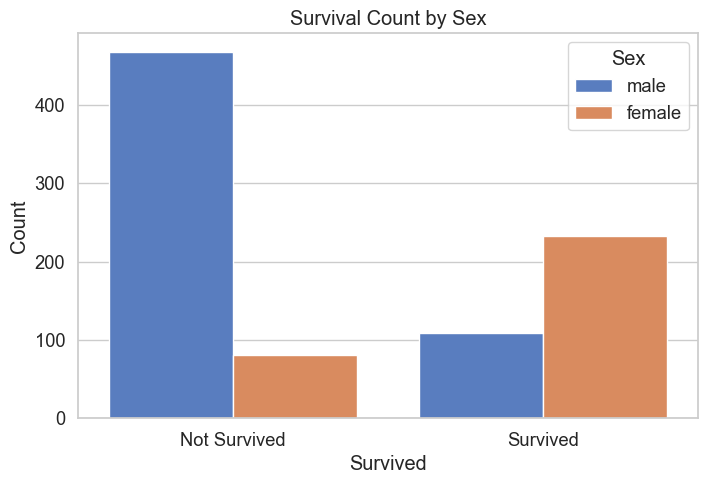

In [206]:
# Checking if Women were more likely to survive
plot_survival_by_sex(train_data)

In [207]:
# Seeing it in percentage
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


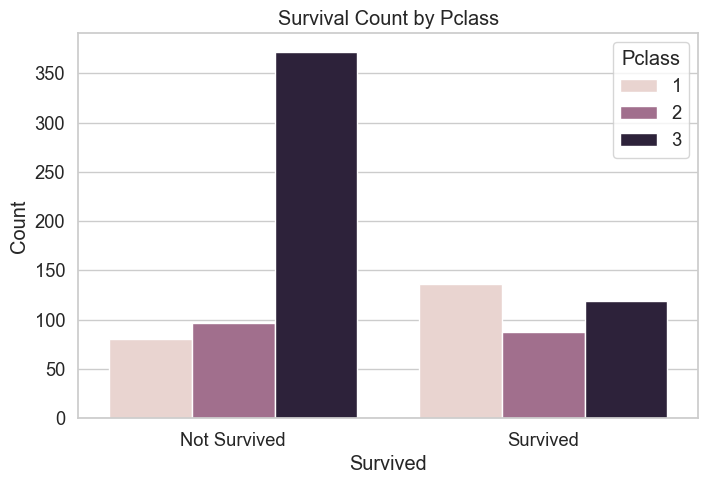

In [208]:
# Checking if Pclass had an impact on survival
plot_survival_by_pclass(train_data)

In [209]:
# Seeing it in percentage
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [210]:
def preprocess_titanic_full(df: pd.DataFrame, scaler: StandardScaler = None, fit_scaler: bool = True) -> pd.DataFrame:
    """
    Complete preprocessing for Titanic dataset:
    - Fill missing values (Age, Fare, Embarked)
    - Extract and simplify Title
    - CabinDeck and HasCabin features
    - Create FamilySize, IsAlone, FarePerPerson
    - One-hot encode categorical features
    - Scale numerical features (optional)
    
    Parameters:
    - df: pd.DataFrame, input dataset
    - scaler: StandardScaler, optional. If provided, used to scale numerical features
    - fit_scaler: bool, if True, fit scaler on this dataset; otherwise, only transform
    
    Returns:
    - pd.DataFrame: preprocessed dataset
    """
    
    dataset = df.copy()
    
    # --------------------------
    # 1. Extract and simplify Title
    # --------------------------
    dataset['Title'] = dataset['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    
    title_mapping = {
        'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
        'Lady': 'Royalty', 'Countess': 'Royalty', 'Dona': 'Royalty',
        'Dr': 'Officer', 'Major': 'Officer', 'Col': 'Officer', 'Capt': 'Officer',
        'Rev': 'Officer', 'Sir': 'Royalty', 'Don': 'Royalty', 'Jonkheer': 'Royalty'
    }
    dataset['Title'] = dataset['Title'].replace(title_mapping)
    
    # --------------------------
    # 2. Fill missing values
    # --------------------------
    dataset['Age'] = dataset.groupby(['Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))
    
    if dataset['Embarked'].isnull().sum() > 0:
        dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])
    
    dataset['Fare'] = dataset.groupby('Pclass')['Fare'].transform(lambda x: x.fillna(x.median()))
    
    # --------------------------
    # 3. Cabin features
    # --------------------------
    dataset['HasCabin'] = dataset['Cabin'].notna().astype(int)
    dataset['CabinDeck'] = dataset['Cabin'].astype(str).str[0]
    dataset['CabinDeck'] = dataset['CabinDeck'].replace('n', 'Unknown')
    
    # --------------------------
    # 4. Family and Fare features
    # --------------------------
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = (dataset['FamilySize'] == 1).astype(int)
    dataset['FarePerPerson'] = dataset['Fare'] / dataset['FamilySize']
    
    # --------------------------
    # 5. One-hot encoding
    # --------------------------
    categorical_features = ['Sex','Embarked','Title','CabinDeck']
    dataset = pd.get_dummies(dataset, columns=categorical_features, drop_first=True)
    
    # --------------------------
    # 6. Scaling numerical features
    # --------------------------
    numeric_features = ['Age','Fare','FamilySize','FarePerPerson']
    
    if scaler is None:
        scaler = StandardScaler()
    
    if fit_scaler:
        dataset[numeric_features] = scaler.fit_transform(dataset[numeric_features])
    else:
        dataset[numeric_features] = scaler.transform(dataset[numeric_features])
    
    return dataset, scaler


In [211]:
train_processed, scaler = preprocess_titanic_full(train_data, fit_scaler=True)
test_processed, _ = preprocess_titanic_full(test_data, scaler=scaler, fit_scaler=False)

print("Processed training data shape:", train_processed.shape)
print("Processed test data shape:", test_processed.shape)

Processed training data shape: (891, 30)
Processed test data shape: (418, 28)


In [212]:
print("Train missing values:\n", train_processed.isnull().sum())
print("Test missing values:\n", test_processed.isnull().sum())

Train missing values:
 PassengerId            0
Survived               0
Pclass                 0
Name                   0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
HasCabin               0
FamilySize             0
IsAlone                0
FarePerPerson          0
Sex_male               0
Embarked_Q             0
Embarked_S             0
Title_Miss             0
Title_Mr               0
Title_Mrs              0
Title_Officer          0
Title_Royalty          0
CabinDeck_B            0
CabinDeck_C            0
CabinDeck_D            0
CabinDeck_E            0
CabinDeck_F            0
CabinDeck_G            0
CabinDeck_T            0
CabinDeck_Unknown      0
dtype: int64
Test missing values:
 PassengerId            0
Pclass                 0
Name                   0
Age                    0
SibSp                  0
Parch                  0
Ticket                 0
Fare             

In [213]:
train_processed.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,HasCabin,FamilySize,IsAlone,FarePerPerson,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",-0.529231,1,0,A/5 21171,-0.502445,NaN,0,0.059160,0,-0.454798,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0.657200,1,0,PC 17599,0.786845,C85,1,0.059160,0,0.438994,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",-0.232623,0,0,STON/O2. 3101282,-0.488854,NaN,0,-0.560975,1,-0.334757,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0.434744,1,0,113803,0.420730,C123,1,0.059160,0,0.185187,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",0.434744,0,0,373450,-0.486337,NaN,0,-0.560975,1,-0.331267,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True


✅ Survival by Sex


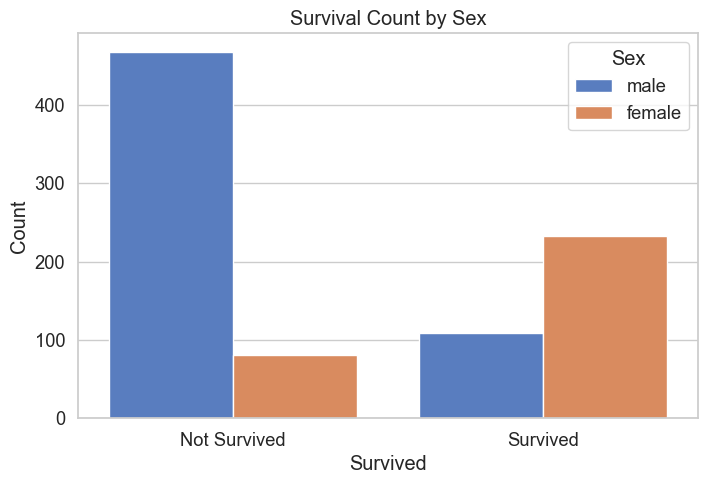

✅ Survival by Pclass


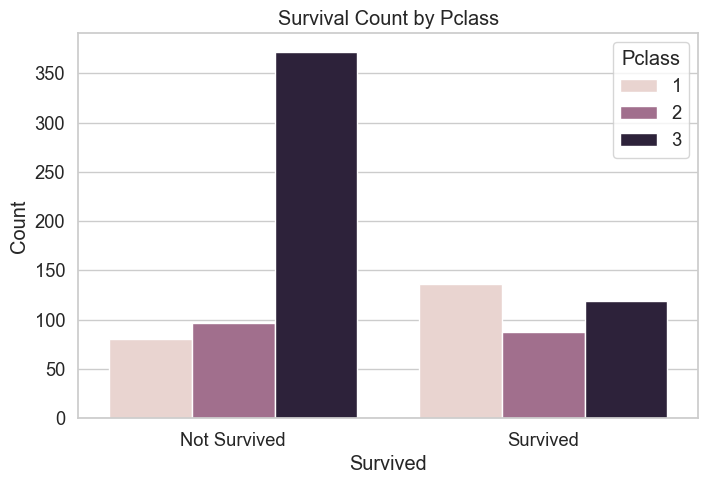

✅ Survival by Sex and Pclass


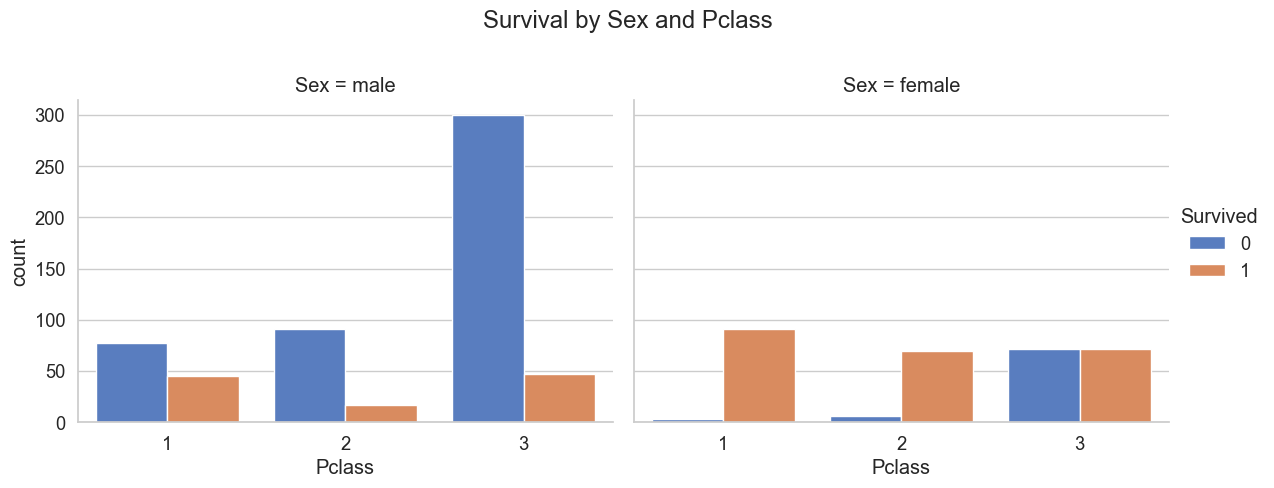

✅ Age Distribution by Survival


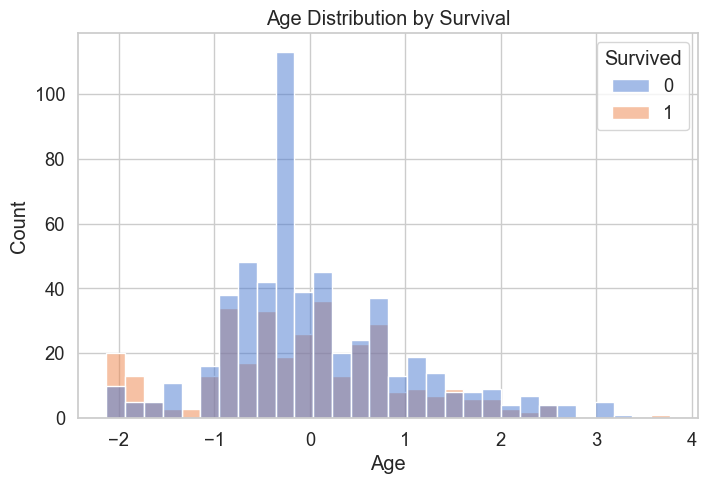

✅ Fare Distribution by Survival


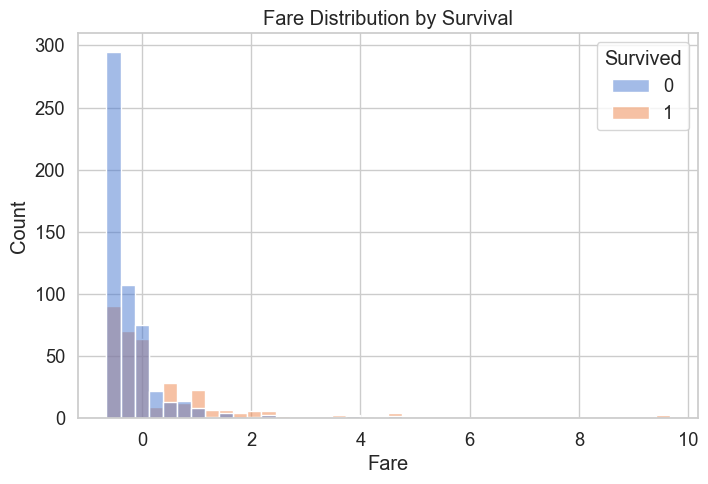

✅ Survival by Cabin Features


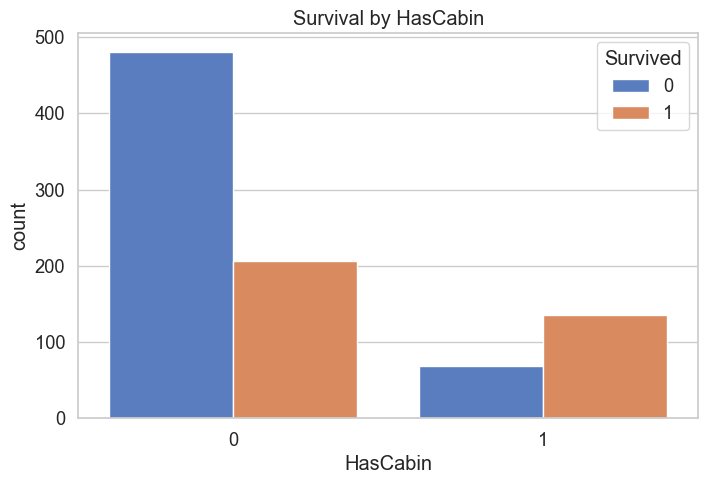

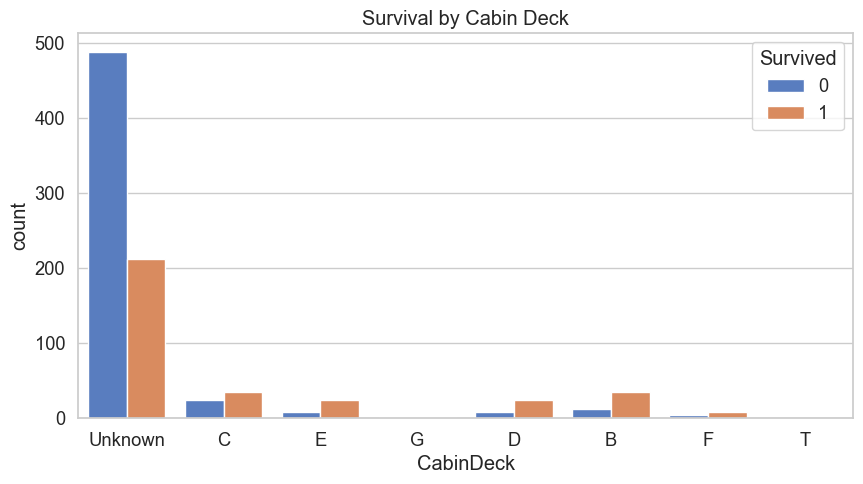

In [214]:
# Visualizing all the graphs after preprocessing

run_full_eda(train_processed)

In [215]:
X_train = train_processed.drop(columns=['Survived', 'Name', 'Ticket', 'Cabin'])
y_train = train_processed['Survived']

X_test = test_processed.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [227]:
# Testing the VoltingClassifier
log_reg = LogisticRegression(max_iter=10000, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=500, random_state=42)
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg),
        ('rf', rf_clf),
        ('xgb', xgb_clf)
    ],
    voting='soft'
)

In [228]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=10000, random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=500, random_state=42),
    "XGBClassifier": xgb.XGBClassifier(eval_metric='logloss', random_state=42),
    "VotingClassifier": voting_clf
}

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{name} Average CV Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

LogisticRegression Average CV Accuracy: 0.8293 ± 0.0367
RandomForestClassifier Average CV Accuracy: 0.8192 ± 0.0399
XGBClassifier Average CV Accuracy: 0.8170 ± 0.0317
VotingClassifier Average CV Accuracy: 0.8338 ± 0.0311


In [229]:
final_model = voting_clf
final_model.fit(X_train, y_train)
predictions = final_model.predict(X_test)

print("Predictions on test set:", predictions)

Predictions on test set: [0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0
 0 1 1 1 1 1 0 1 0 0 1]


In [219]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# y_pred_val = ensemble.predict(X_val)
# print("Accuracy:", accuracy_score(y_val, y_pred_val))
# print("F1 Score:", f1_score(y_val, y_pred_val))
# print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))


In [223]:
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': predictions
})

submission.to_csv('../data/processed/submission.csv', index=False)